<a href="https://colab.research.google.com/github/Benylaode/Analisi-Sentimen-KU/blob/main/Analsisi_Sentimen_JKN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lakukan Penginstall Beberapa Depedens **

In [145]:
pip install --upgrade gensim

In [146]:
pip install Sastrawi

In [147]:
pip install keras==2.15.0 scikit-learn==1.4.1.post1 nltk==3.8.1 tensorflow==2.15.0

**Impoert beberapa depedensi umum yang mungkin digunakan**

catatan :
jika terjadi error maka restart sension saja (biasa terjadi karena depedensi belum terintsall dengan baik)

In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle

In [149]:
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**import dan ambil dataset**

In [150]:
import pandas as pd

csv_path = 'ulasan_playstore (1).csv'
df = pd.read_csv(csv_path)

total_tasks = len(df)
max_threads = 1

In [151]:
df

,rating,ulasan,tanggal,nama_pengguna
0,negatif,"APLIKASI SAMPAH, dana buat bikin aplikasi di K...",8 April 2025,felisya
1,negatif,"Aplikasi Rusak!! Issue critical gak fix""dari t...",1 Mei 2025,Harlly Pundoko
2,negatif,"Aplikasi jelek, sebenernya dibuat untuk memuda...",23 April 2025,nur laeli
3,negatif,"Kirain cuman sendiri yg OTPnya ga ke kirim, li...",2 Mei 2025,Baiq Nada
4,negatif,Penambahan fitur dan menu didalam aplikasi ini...,8 April 2025,Yoel Pratama
...,...,...,...,...
4995,positif,Bisa perubahan data scra online mantap skalii ...,3 Februari 2025,Resa Khudaifa
4996,negatif,aplikasi pemerintah kebanyakan emang gagal ya....,14 Februari 2025,Fajar Edi Wibowo
4997,negatif,mw daftar gabisa. minta verifikasi no hp ga ma...,7 Februari 2025,Lutfi Yoo (Loetfi Photograph)
4998,positif,"Hallo Mobile Jkn, saya sudah berkali² daftar s...",27 Mei 2023,arie burhan


**LAKUKAN LABELING AGAR DAPAT DIOLEH OLEH MACHINE**

In [152]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['rating'] = le.fit_transform(df['rating'])

In [153]:
df

,rating,ulasan,tanggal,nama_pengguna
0,0,"APLIKASI SAMPAH, dana buat bikin aplikasi di K...",8 April 2025,felisya
1,0,"Aplikasi Rusak!! Issue critical gak fix""dari t...",1 Mei 2025,Harlly Pundoko
2,0,"Aplikasi jelek, sebenernya dibuat untuk memuda...",23 April 2025,nur laeli
3,0,"Kirain cuman sendiri yg OTPnya ga ke kirim, li...",2 Mei 2025,Baiq Nada
4,0,Penambahan fitur dan menu didalam aplikasi ini...,8 April 2025,Yoel Pratama
...,...,...,...,...
4995,1,Bisa perubahan data scra online mantap skalii ...,3 Februari 2025,Resa Khudaifa
4996,0,aplikasi pemerintah kebanyakan emang gagal ya....,14 Februari 2025,Fajar Edi Wibowo
4997,0,mw daftar gabisa. minta verifikasi no hp ga ma...,7 Februari 2025,Lutfi Yoo (Loetfi Photograph)
4998,1,"Hallo Mobile Jkn, saya sudah berkali² daftar s...",27 Mei 2023,arie burhan


**DEFINISIKAN BEBERAPA KELAS DAN FUNGSI YANG AKAN DI PAKAI**

In [154]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, (hn, _) = self.lstm2(x)
        x = self.dropout(hn[-1])
        x = self.fc(x)
        return x

In [155]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, outputs, targets):
        logp = self.ce(outputs, targets)
        p = torch.exp(-logp)
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * ((1 - p) ** self.gamma) * logp
        else:
            loss = ((1 - p) ** self.gamma) * logp
        return loss.mean()

In [156]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import torch
import numpy as np
from collections import Counter

def balance_data(X, y, method='undersample'):
    y = np.array(y)  # pastikan numpy array
    X_flat = X.reshape((X.shape[0], -1))  # flatten data

    if method == 'oversample':
        # Hitung distribusi kelas
        class_counts = Counter(y)
        min_class = min(class_counts, key=class_counts.get)
        max_class = max(class_counts, key=class_counts.get)
        min_count = class_counts[min_class]
        max_allowed = 2 * min_count

        # Jika jumlah data mayoritas lebih dari 2x minoritas, potong dulu
        if class_counts[max_class] > max_allowed:
            # Ambil indeks dari masing-masing kelas
            min_indices = np.where(y == min_class)[0]
            max_indices = np.where(y == max_class)[0]
            np.random.seed(42)
            np.random.shuffle(max_indices)
            max_indices = max_indices[:max_allowed]

            selected_indices = np.concatenate([min_indices, max_indices])
            X_flat = X_flat[selected_indices]
            y = y[selected_indices]

        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_flat, y)

    elif method == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_flat, y)

    else:
        raise ValueError("Method harus 'undersample' atau 'oversample'.")

    # Kembalikan ke bentuk asli dan konversi ke tensor
    X_resampled = X_resampled.reshape((-1, X.shape[1], X.shape[2]))
    X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
    y_tensor = torch.tensor(y_resampled, dtype=torch.long)
    return X_tensor, y_tensor

In [157]:
import numpy as np

class F1Score:
    def __init__(self):
        self.true_positives = 0
        self.false_positives = 0
        self.false_negatives = 0

    def update_state(self, y_true, y_pred):
        y_true = np.round(y_true).astype(bool)
        y_pred = np.round(y_pred).astype(bool)

        self.true_positives += np.sum(y_true & y_pred)
        self.false_positives += np.sum(~y_true & y_pred)
        self.false_negatives += np.sum(y_true & ~y_pred)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)
        return 2 * (precision * recall) / (precision + recall + 1e-7)

    def reset_state(self):
        self.true_positives = 0
        self.false_positives = 0
        self.false_negatives = 0

In [158]:
import tensorflow as tf
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# **PREPROSESING DATA**

**PEMBERSIHAN DATA**

In [159]:
import re
import string
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from joblib import Parallel, delayed, Memory

import os

# Setup joblib memory cache directory
cachedir = './cache_stemming'
memory = Memory(cachedir, verbose=0)

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Inisialisasi
stop_words = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Caching fungsi stemming satu kata
@memory.cache
def cached_stem(word):
    return stemmer.stem(word)

# Bersihkan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Tokenisasi dan filter stopwords
def tokenize_filter(text):
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words and len(word) > 2]

# Preprocessing satu kalimat
def preprocess_single(text):
    cleaned = clean_text(text)
    tokens = tokenize_filter(cleaned)
    stemmed = [cached_stem(word) for word in tokens]
    return ' '.join(stemmed)

# Load data
# df = pd.read_csv('ulasan_playstore.csv')
df = df.dropna(subset=['ulasan'])

# Paralelisasi dengan caching stemming
cleaned_list = Parallel(n_jobs=-1, backend="threading")(
    delayed(preprocess_single)(text) for text in df['ulasan']
)

# Simpan hasil
df['cleaned'] = cleaned_list
df = df[df['cleaned'].str.strip().astype(bool)]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [160]:
df

,rating,ulasan,tanggal,nama_pengguna,cleaned
0,0,"APLIKASI SAMPAH, dana buat bikin aplikasi di K...",8 April 2025,felisya,aplikasi sampah dana bikin aplikasi korupsi sa...
1,0,"Aplikasi Rusak!! Issue critical gak fix""dari t...",1 Mei 2025,Harlly Pundoko,aplikasi rusak issue critical gak fixdari daft...
2,0,"Aplikasi jelek, sebenernya dibuat untuk memuda...",23 April 2025,nur laeli,aplikasi jelek sebenernya mudah sulit masyarak...
3,0,"Kirain cuman sendiri yg OTPnya ga ke kirim, li...",2 Mei 2025,Baiq Nada,kirain cuman otpnya kirim liat ulas trnyata ng...
4,0,Penambahan fitur dan menu didalam aplikasi ini...,8 April 2025,Yoel Pratama,tambah fitur menu dalam aplikasi sederhana apl...
...,...,...,...,...,...
4995,1,Bisa perubahan data scra online mantap skalii ...,3 Februari 2025,Resa Khudaifa,ubah data scra online mantap skalii jdi ribet ...
4996,0,aplikasi pemerintah kebanyakan emang gagal ya....,14 Februari 2025,Fajar Edi Wibowo,aplikasi perintah banyak emang gagal miris gen...
4997,0,mw daftar gabisa. minta verifikasi no hp ga ma...,7 Februari 2025,Lutfi Yoo (Loetfi Photograph),daftar gabisa verifikasi masuk masuk foto waja...
4998,1,"Hallo Mobile Jkn, saya sudah berkali² daftar s...",27 Mei 2023,arie burhan,hallo mobile jkn kali daftar input kode otp ma...


**PENENTUAN VECTOR SIZE DAN MAXLEN**

In [161]:
from gensim.utils import simple_preprocess
list_data = df['cleaned'].tolist()
tokenized_data = [simple_preprocess(text) for text in df['cleaned']]


a = [len(i) for i in tokenized_data]
maxlen = min(max(a), 50)
vector_size = 768

**PENGGUNAAN MODEL WORD2VEC UNTUK TOKENISASI DATA DALAM BENTUK KALIMAT**

In [162]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = list_data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(corpus)
model1 = Word2Vec(tokenized_data, vector_size=vector_size, window=5, min_count=1, sg=0)

token_str = " ".join(list_data[1])
tfidf_scores = tfidf_vectorizer.transform([list_data[1]])
print(list_data[1])
print(tfidf_scores)
print("Vektor untuk kata 'critical':")
print(model1.wv['critical'])

aplikasi rusak issue critical gak fixdari daftar aja gak kirim verifikasi otp respon sampe tunggu abis kode pas switch aplikasi messageemail app jkn langsung trus selesai proses daftar kalo pindah app langsung mohon baik
  (0, 7559)	0.07201277441003491
  (0, 7387)	0.16080134791800152
  (0, 7343)	0.15413205820647277
  (0, 6878)	0.28342467401165095
  (0, 6375)	0.17939967420952818
  (0, 6188)	0.14207914216224166
  (0, 6089)	0.20361050981769027
  (0, 5945)	0.18068462885591885
  (0, 5742)	0.13215653007713812
  (0, 5593)	0.15651237533350176
  (0, 5336)	0.11472384421852577
  (0, 5235)	0.09449958103497043
  (0, 4592)	0.12143196478207871
  (0, 4481)	0.28342467401165095
  (0, 3841)	0.28575437052829905
  (0, 3553)	0.09098133407130808
  (0, 3500)	0.11084741269736872
  (0, 3242)	0.11903684941358976
  (0, 3125)	0.1013104658237576
  (0, 2967)	0.27040130401252926
  (0, 2381)	0.17475426355840643
  (0, 2275)	0.28342467401165095
  (0, 1557)	0.13407221573052774
  (0, 1522)	0.28342467401165095
  (0, 631)	0

In [163]:


def tokens_to_sequence_tfidf(tokens, model1, tfidf_vectorizer, idf_dict=None, maxlen=100, vector_size=100):
    sequence = []

    token_str = " ".join(tokens)
    tfidf_scores = tfidf_vectorizer.transform([token_str])
    tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_scores.toarray()[0]))

    for word in tokens:
        if word in model1.wv or word in tfidf_dict:
            vector = model1.wv[word]
            if len(vector) == vector_size:
                weight = tfidf_dict[word]

                weighted_vector = vector * weight
                sequence.append(weighted_vector)

    while len(sequence) < maxlen:
        sequence.append(np.zeros(vector_size))

    if len(sequence) > maxlen:
        sequence = sequence[:maxlen]

    return np.array(sequence, dtype=np.float32)


Membuat Token

In [164]:
X = np.array([
    tokens_to_sequence_tfidf(tokens, model1, tfidf_vectorizer, None, maxlen=maxlen, vector_size=vector_size)
    for tokens in tokenized_data
])
X_text = df['cleaned'].tolist()

In [165]:
list_ulasan = df['rating'].dropna().tolist()
y = list_ulasan

In [166]:
le = LabelEncoder()
y = le.fit_transform(y)

In [167]:
print("Shape X_padded:", X[35])

Shape X_padded: [[-0.01967984 -0.04011259 -0.01172476 ... -0.00754832  0.01129768
   0.01153243]
 [-0.01868109 -0.0281989  -0.0129178  ... -0.01967949  0.0014259
   0.00440229]
 [-0.02270243 -0.03462892 -0.01472722 ... -0.02280372  0.00152426
   0.00594478]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


Membuat Model

**SEQUENCE DATA YANG DI DAPAT KEMUDIAN DI PISAHKAN UNTUK EVALUSI DAN TRAINING**

In [168]:
unique, counts = np.unique(y, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 3941, 1: 1058}


In [169]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Asumsi:
# - X = array Word2Vec (shape: [num_samples, 768])
# - X_text = list teks asli (shape: [num_samples])
# - df['rating'] = label kategorikal (belum di-encode)

# 1. Encode label
le = LabelEncoder()
y = le.fit_transform(df['rating'])  # Konversi label ke numerik (0, 1, 2, ...)

# 2. Generate array indeks
indices = np.arange(len(X))

# 3. Split indeks dengan stratifikasi (stratify=y)
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=y,  # Mempertahankan distribusi label
    random_state=42
)

# 4. Terapkan indeks ke X, X_text, dan y
X_train, X_test = X[train_indices], X[test_indices]
X_text_train, X_test_text = [X_text[i] for i in train_indices], [X_text[i] for i in test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Verifikasi
print("=== Distribusi Label ===")
print(f"Training: {np.bincount(y_train)}")
print(f"Testing: {np.bincount(y_test)}")
print("\n=== Jumlah Data ===")
print(f"Total Training: {len(X_train)}")
print(f"Total Testing: {len(X_test)}")

=== Distribusi Label ===
Training: [3153  846]
Testing: [788 212]

=== Jumlah Data ===
Total Training: 3999
Total Testing: 1000


In [170]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3999, 50, 768)
(3999,)
(1000, 50, 768)
(1000,)


MENDEFINISIKAN INPUT SIZE

In [171]:

input_size = X_train.shape[2]

**MENYESUIKAN DATA YANG TIDAK BALANCE DENGAN FUNGSI BALANCE_DATA DENGAN OVERSAMPEL DENGAN SMOTE**

In [172]:
# Balancing sebelum konversi ke numpy
X_train_balanced, y_train_balanced = balance_data(X_train, y_train, method='oversample')

# Baru konversi ke numpy
X_train_np = X_train_balanced.numpy()
y_train_np = y_train_balanced.numpy()

# X_train_np = X_train
# y_train_np = y_train

**DATA TESTING DI UNDERSAMPLE**

In [173]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from collections import Counter

test_data = list(zip(X_test, X_test_text, y_test))

X_test_temp = np.array([item[0] for item in test_data])
y_test_temp = np.array([item[2] for item in test_data])

# Option 2 solution:
dummy_X = np.zeros((len(y_test_temp), 1))
undersampler = RandomUnderSampler(random_state=42)
_, _ = undersampler.fit_resample(dummy_X, y_test_temp)
selected_indices = undersampler.sample_indices_

X_test = X_test_temp[selected_indices]
X_test_text = [test_data[i][1] for i in selected_indices]
y_test = y_test_temp[selected_indices]

# Verification
print(f"After balancing: {Counter(y_test)}")
print(f"Text count: {len(X_test_text)}")
print(f"X_test_balanced shape: {X_test}")

After balancing: Counter({0: 212, 1: 212})
Text count: 424
X_test_balanced shape: [[[-0.02440676 -0.04488499 -0.01524907 ... -0.01368962  0.01025082
    0.01049968]
  [-0.00909829 -0.01854466 -0.00542054 ... -0.00348971  0.00522309
    0.00533162]
  [-0.01635937 -0.02540543 -0.01258103 ... -0.01998611  0.00152731
    0.00387777]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.01144008 -0.01878377 -0.00802724 ... -0.00836683  0.00278205
    0.00371431]
  [-0.04596487 -0.09165724 -0.02974031 ... -0.01784679  0.02441819
    0.02460337]
  [-0.01615927 -0.0358821  -0.00985864 ... -0.00292747  0.01180342
    0.01089479]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0. 

In [174]:
X_train_flat = X_train_np.reshape(X_train_np.shape[0], -1)
df_train = pd.DataFrame(X_train_flat)
df_train['target'] = y_train_np

In [175]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,38391,38392,38393,38394,38395,38396,38397,38398,38399,target
0,-0.022427,-0.036823,-0.015736,0.020536,0.042356,-0.033819,0.009620,0.052097,-0.047081,0.002294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.010700,-0.021810,-0.006375,0.012279,0.021941,-0.016974,0.005835,0.028540,-0.020591,0.002563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.022861,-0.041467,-0.015099,0.022170,0.044895,-0.034046,0.011334,0.056739,-0.044944,0.004169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.035151,-0.057716,-0.024665,0.032188,0.066389,-0.053007,0.015078,0.081657,-0.073795,0.003596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.015214,-0.031000,-0.009524,0.017153,0.029301,-0.023053,0.008599,0.040019,-0.029440,0.003058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379,-0.000650,-0.001121,0.000100,0.001312,0.000456,-0.000955,-0.000161,0.001326,-0.001227,-0.000194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3380,-0.004134,-0.006510,-0.002857,0.003081,0.007676,-0.006047,0.001575,0.009349,-0.008387,0.000289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3381,-0.013598,-0.022327,-0.009541,0.012452,0.025682,-0.020505,0.005833,0.031588,-0.028547,0.001391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3382,-0.011798,-0.023448,-0.007234,0.013046,0.024082,-0.018554,0.006298,0.031015,-0.022993,0.002675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [176]:
# Menghitung jumlah baris duplikat
num_duplicates = df_train.duplicated().sum()
print(f'Jumlah baris duplikat: {num_duplicates}')

Jumlah baris duplikat: 0


<ipython-input-177-7b9d1fdd7098>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


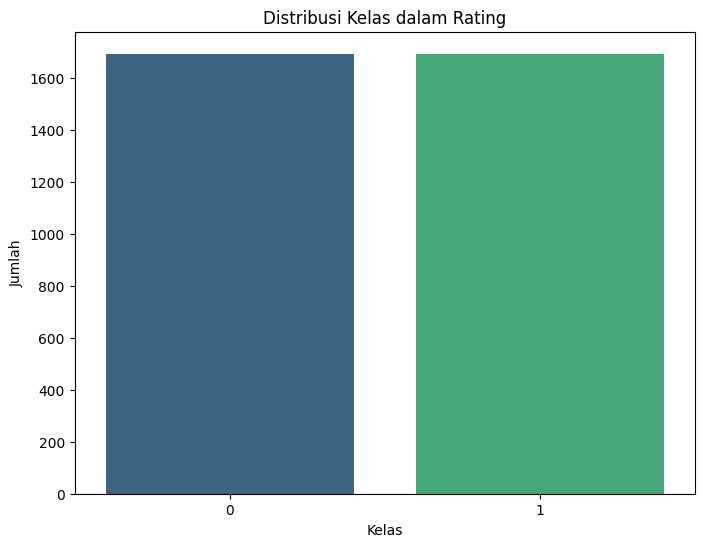

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung distribusi kelas dalam kolom 'rating'
class_distribution = df_train['target'].value_counts()

# Visualisasi menggunakan Bar Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Distribusi Kelas dalam Rating')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)  # Agar label di sumbu x tidak miring
plt.show()

# **PELATIHAN MODEL LSTM YANG SUDAH DI DEFINISIKAN**

In [178]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.utils import class_weight
from collections import Counter


# --- Model Architecture ---
inputs = Input(shape=(maxlen, input_size))
x = Masking(mask_value=0.0)(inputs)
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = LSTM(128)(x)  # LSTM otomatis menerima mask
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
initial_lr = 0.001
# --- Optimizer and Learning Rate Schedule ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=100000, decay_rate=0.96, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

# --- Compile Model with Metrics ---
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy'
    ]
)

# --- Callbacks ---
# Monitor 'val_loss' untuk modifikasi learning rate dan penghentian dini training
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',               # Karena recall lebih baik jika nilainya tinggi
    save_best_only=True,
    verbose=1
)

# Gabungkan semua callback
callbacks = [lr_scheduler, model_checkpoint]

# Build model (opsional, untuk memastikan model telah dibangun dengan bentuk input yang diharapkan)
model.build(input_shape=(None, maxlen, input_size))
model.summary()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)

# Buat dictionary-nya
class_weights_dict = dict(enumerate(class_weights))
# --- Training ---
#class_weight=class_weights_dict

class_counts = Counter(y_train_np)

# Ambil mayoritas dan minoritas berdasarkan jumlah
mayoritas = max(class_counts, key=class_counts.get)
minoritas = min(class_counts, key=class_counts.get)

custom_class_weights = class_weights_dict.copy()

# Ubah sesuai permintaan
custom_class_weights[minoritas] *= 1.35
custom_class_weights[mayoritas] *= 0.98

try:
    history = model.fit(
        X_train_np,
        y_train_np,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight=class_weights_dict

    )
except Exception as e:
    print(f"Error during training: {e}")

np.save('training_history.npy', history.history)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 768)]         0         
                                                                 
 masking_8 (Masking)         (None, 50, 768)           0         
                                                                 
 lstm_16 (LSTM)              (None, 50, 128)           459264    
                                                                 
 dropout_16 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129 

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.7311
Epoch 2: val_accuracy improved from 0.37518 to 0.48301, saving model to best_model.h5
85/85 [==============================] - 23s 273ms/step - loss: 0.5647 - accuracy: 0.7311 - val_loss: 0.6734 - val_accuracy: 0.4830 - lr: 0.0010
Epoch 3/200
85/85 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.7451
Epoch 3: val_accuracy did not improve from 0.48301
85/85 [==============================] - 24s 276ms/step - loss: 0.5469 - accuracy: 0.7451 - val_loss: 0.7375 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 4/200
85/85 [==============================] - ETA: 0s - loss: 0.5397 - accuracy: 0.7521
Epoch 4: val_accuracy did not improve from 0.48301
85/85 [==============================] - 24s 289ms/step - loss: 0.5397 - accuracy: 0.7521 - val_loss: 0.9840 - val_accuracy: 0.3323 - lr: 0.0010
Epoch 5/200
85/85 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7562
Epoch 5: 

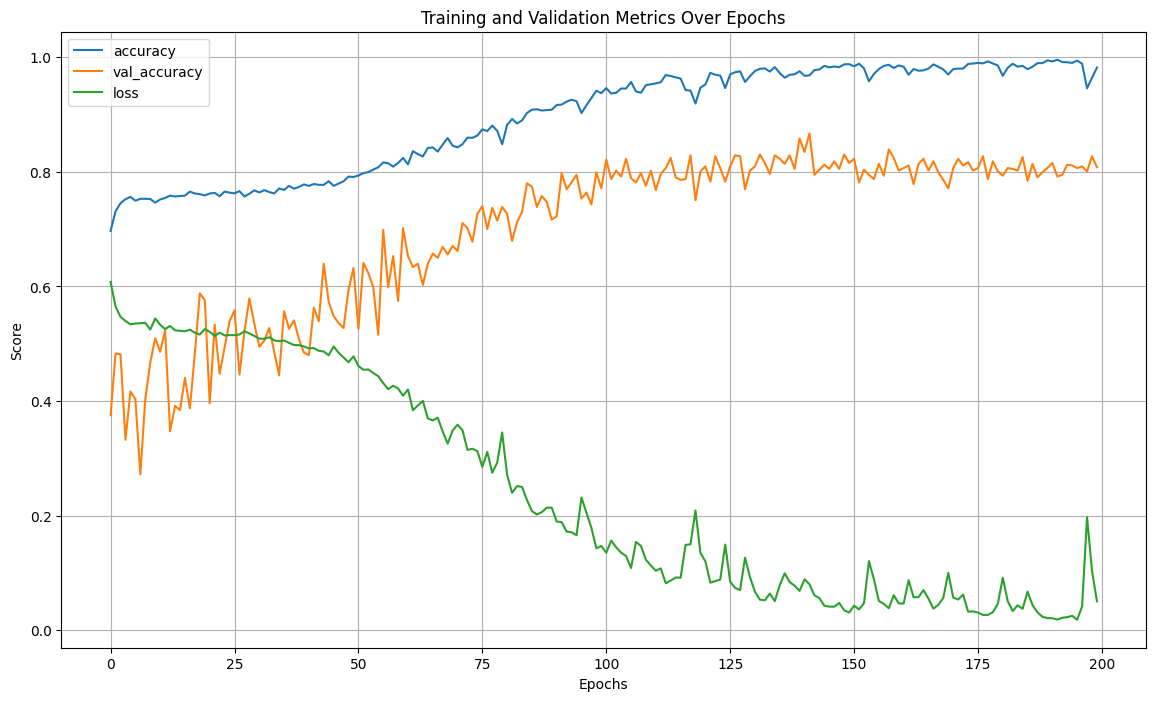

In [179]:
import matplotlib.pyplot as plt

# Load history jika belum tersedia di variabel
history_data = np.load('training_history.npy', allow_pickle=True).item()

# Plot metrik
metrics = ['accuracy', 'val_accuracy', 'loss']

plt.figure(figsize=(14, 8))
for metric in metrics:
    plt.plot(history_data[metric], label=metric)
plt.title("Training and Validation Metrics Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

**melihat perfoma model di testing**

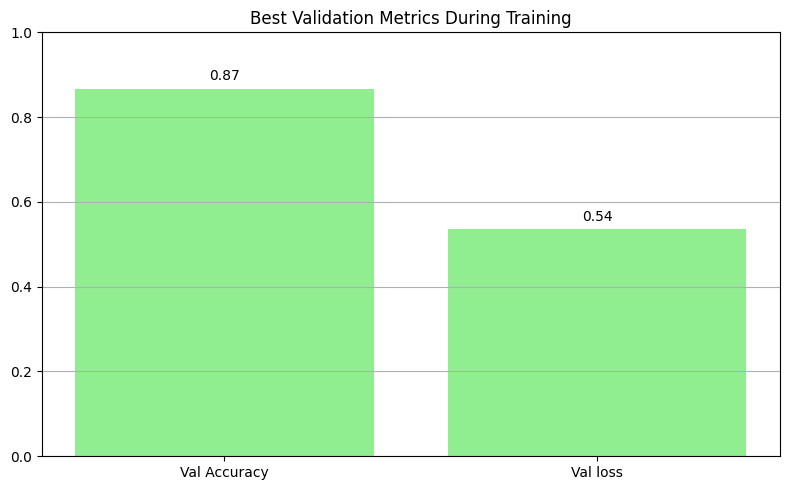

In [180]:
import numpy as np
import matplotlib.pyplot as plt

# Load history
history_data = np.load('training_history.npy', allow_pickle=True).item()

# Ambil nilai terbaik (maksimum) dari metrik validasi
best_val_metrics = {
    'Val Accuracy': max(history_data['val_accuracy']),
    'Val loss': min(history_data['val_loss']),
}

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(best_val_metrics.keys(), best_val_metrics.values(), color='lightgreen')
plt.title("Best Validation Metrics During Training")
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [185]:
model = tf.keras.models.load_model('best_model.h5')

 Melakukan prediksi dengan model latih

14/14 [==============================] - 4s 79ms/step


<Figure size 600x600 with 0 Axes>

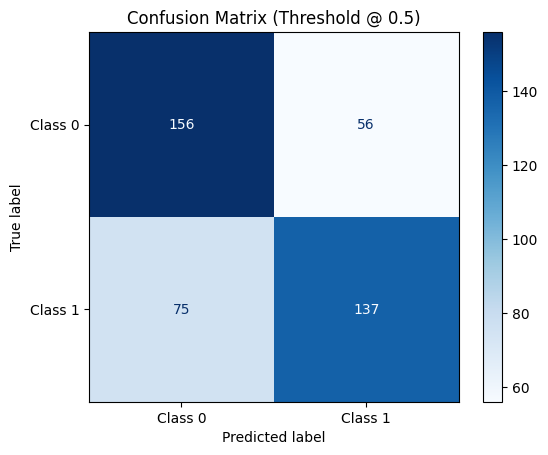

In [186]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- 1. Prediksi probabilitas dari model Keras ---
y_pred_probs = model.predict(X_test)  # Sudah berupa probabilitas

# --- 2. Threshold (misal 0.5) ---
y_pred = (y_pred_probs > 0.5).astype("int32")

# --- 3. Confusion Matrix dan Visualisasi ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Threshold @ 0.5)')
plt.grid(False)
plt.show()

**Training ulang untuk meningkatkan kemampuan mode**

model suda cukup baik dalam membedakan antara class satu dan lainya